# Validation Dataset

## Validation dataset sources

| Dataset 	| Reference 	| Disease 	| Raw Data Source 	| Download Sample Size 	| Population 	| Platform 	|
|---	|---	|---	|---	|---	|---	|---	|
| StJude AML02 	| [Rubnitz et al., 2010](https://pubmed.ncbi.nlm.nih.gov/20451454/) 	| AML 	| St. Jude Children's 	| 159 	| Pediatric 	| 450k 	|
| StJude AML08 	| [Rubnitz et al., 2019](https://pubmed.ncbi.nlm.nih.gov/31246522/) 	| AML 	| St. Jude Children's 	| 42 	| Pediatric 	| 450k 	|

```{note}
The downloaded data contained an additional 95 liver methylation samples, so the total number of samples initially is 324. These will be filtered out in further steps.
```

## Step 1. Process raw data to get methylation beta values


    python -m methylprep -v process -d <directory> --all --batch_size 199
    

```{note}
From this point on we will move from using `python3.7` to using `python3.8`.
```

### Where the data at?

In [1]:
mount = '/mnt/e/ALMA/'

input_path_test_data = mount + 'Raw_Data/LambaPrivate_StJude_AML02_AML08_Methyl450k/'

zhou2016_probes_path = mount + 'UnreliableProbesList_Zhou2016/EPIC.anno.GRCh38.tsv'

output_path = mount + 'Intermediate_Files/'

### Load Dataframes

In [2]:
import methylcheck
import pandas as pd

# Load the dataframes from the input paths
df = methylcheck.load(input_path_test_data, silent=True)

# Sort sample index
df = df.T.sort_index().T

print(f' Dataset (df) contains {df.shape[0]} rows (5mC sites/probes) and {df.shape[1]} columns (samples).')

 Dataset (df) contains 485512 rows (5mC sites/probes) and 324 columns (samples).


## Step 2. Load and process clinical data

In [3]:
# Import functions to clean up clinical data
import sys
sys.path.append('../')
from utils.clinical_data_cleanup import *

# Call functions to merge, index and clean clinical data files
labels_aml02         = clean_aml02       (merge_index_aml02())
labels_aml08         = clean_aml08       (merge_index_aml08())


# Combine all clinical data labels into one dataframe
labels_combined = pd.concat([labels_aml02, labels_aml08] ,axis=0, join='outer')

# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df.T.index)].sort_index()

print('The clinical data has been indexed and cleaned.\n\
Exclusion of samples may be applied depending on the analysis.')

The clinical data has been indexed and cleaned.
Exclusion of samples may be applied depending on the analysis.


### Evaluate missing values

<Axes: >

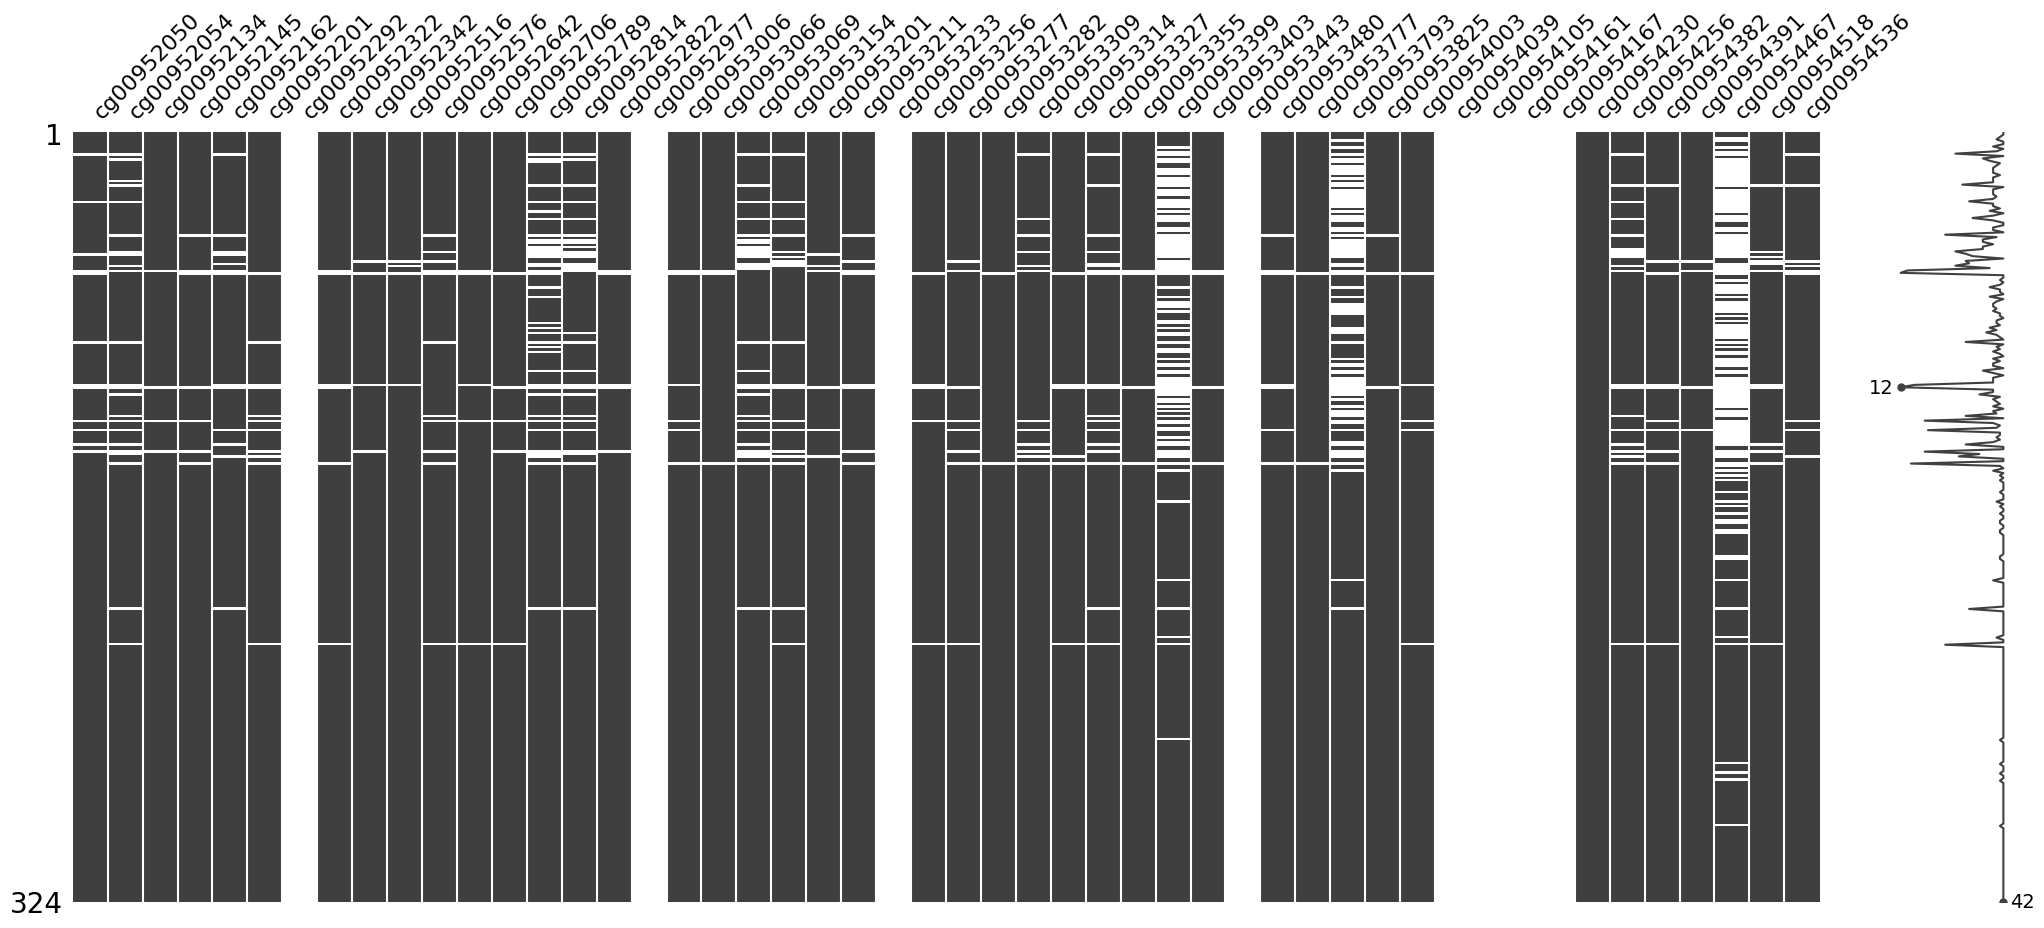

In [4]:
import missingno as msno

# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 3. Remove suboptimal CpGs

In [5]:
def exclude_suboptimal_probes(df):
    '''This function removes proves listed as sub-optimal according to:
    
    Zhou, W., Laird, P. W. & Shen, H.. Comprehensive characterization,
    annotation and innovative use of Infinium DNA methylation BeadChip probes.
    Nucleic Acids Research gkw967 (2016).
    doi:10.1093/nar/gkw967

    For the .tsv file containing the annotated probes, download the paper's
    supplementary material.
    '''
    # Load the list of suboptimal probes
    zhou2016_probes = pd.read_csv(zhou2016_probes_path, sep='\t',index_col=0)

    # Select the probes that are listed as suboptimal
    unreliable_probes = list(zhou2016_probes[zhou2016_probes['MASK.general'] == True].index)

    # Remove the unreliable probes from the dataframe
    df_ = df[~df.index.isin(unreliable_probes)]
    
    print(
        f'Removed {df.shape[0]-df_.shape[0]} suboptimal probes. {df_.shape[0]} probes remaining.')

    return(df_)

df = exclude_suboptimal_probes(df)

Removed 47514 suboptimal probes. 437998 probes remaining.


## Step 4. Remove sex-linked CpGs

In [6]:
df = methylcheck.exclude_sex_control_probes(df, '450k', no_sex=True, no_control=False, verbose=True)

450k: Removed 10623 sex-linked probes from 324 samples. 427375 probes remaining.


## Step 5. Remove non-hematopoietic samples

In [7]:
import pandas as pd

def remove_non_hematopoietic_samples(df1: pd.DataFrame, df_labels: pd.DataFrame) -> pd.DataFrame:
    """
    Function to remove samples not present in the AML02 or AML08 clinical dataset.
    
    Args:
    df1: DataFrame containing the initial set of samples.
    df_labels: DataFrame containing the clinical dataset.
    
    Returns:
    df2: DataFrame after removing samples not present in the clinical dataset.
    """

    df2 = df1.T.loc[df1.T.index.isin(df_labels.index)].T

    print(
        f'Removed {df1.shape[1]-df2.shape[1]} samples not present in AML02 or AML08 clinical datasets.\
 {df2.shape[1]} samples remaining.')
    
    return df2

df = remove_non_hematopoietic_samples(df, df_labels)


Removed 95 samples not present in AML02 or AML08 clinical datasets. 229 samples remaining.


## Step 6. Exclude samples in which >20% of probes have failed p-values

In [8]:
def exclude_failed_samples(df2):
    '''This function removes samples that have more than 20% NaN values.'''

    # Calculate the number of NaN values in each sample
    nan_count = df2.isna().sum()

    # Calculate the total number of probes (rows) in the DataFrame
    total_probes = df2.shape[0]

    # Calculate the percentage of NaN values for each sample
    nan_percentage = (nan_count / total_probes) * 100

    # Identify samples that meet the condition of having more than 20% NaN values
    samples_to_exclude = nan_percentage[nan_percentage > 20].index

    # Exclude samples that meet the condition from the DataFrame
    filtered_df2 = df2.drop(samples_to_exclude, axis=1)
    
    # Print the number of samples before and after filtering
    print(
    f"Removed {df2.shape[1]-filtered_df2.shape[1]} samples ({round((df2.shape[1]-filtered_df2.shape[1])/df2.shape[1]*100,2)}%). {filtered_df2.shape[1]} samples remaining."
    )
    
    return filtered_df2

df = exclude_failed_samples(df)


Removed 28 samples (12.23%). 201 samples remaining.


### Evaluate missing values

<Axes: >

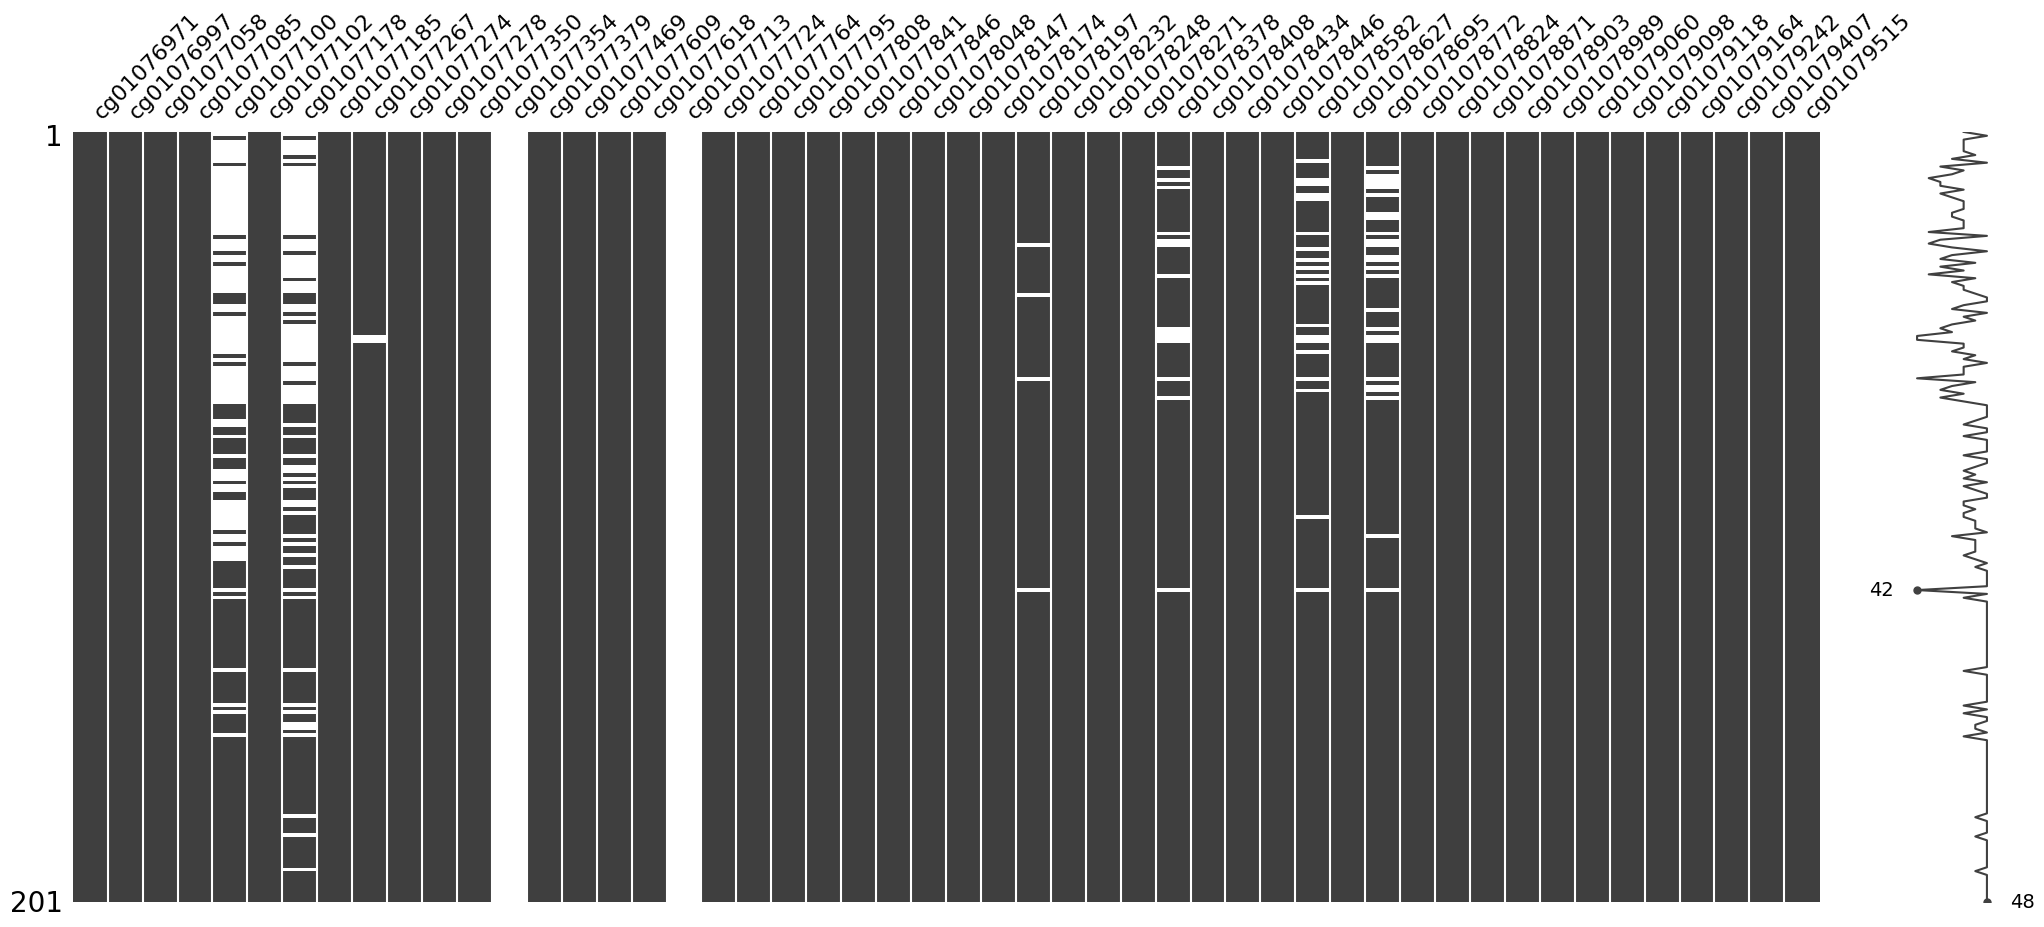

In [9]:
# Plot the missing values
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 7. Impute remaining missing values

This step will also automatically remove extra CpGs that are not in the discovery dataset.

<Axes: >

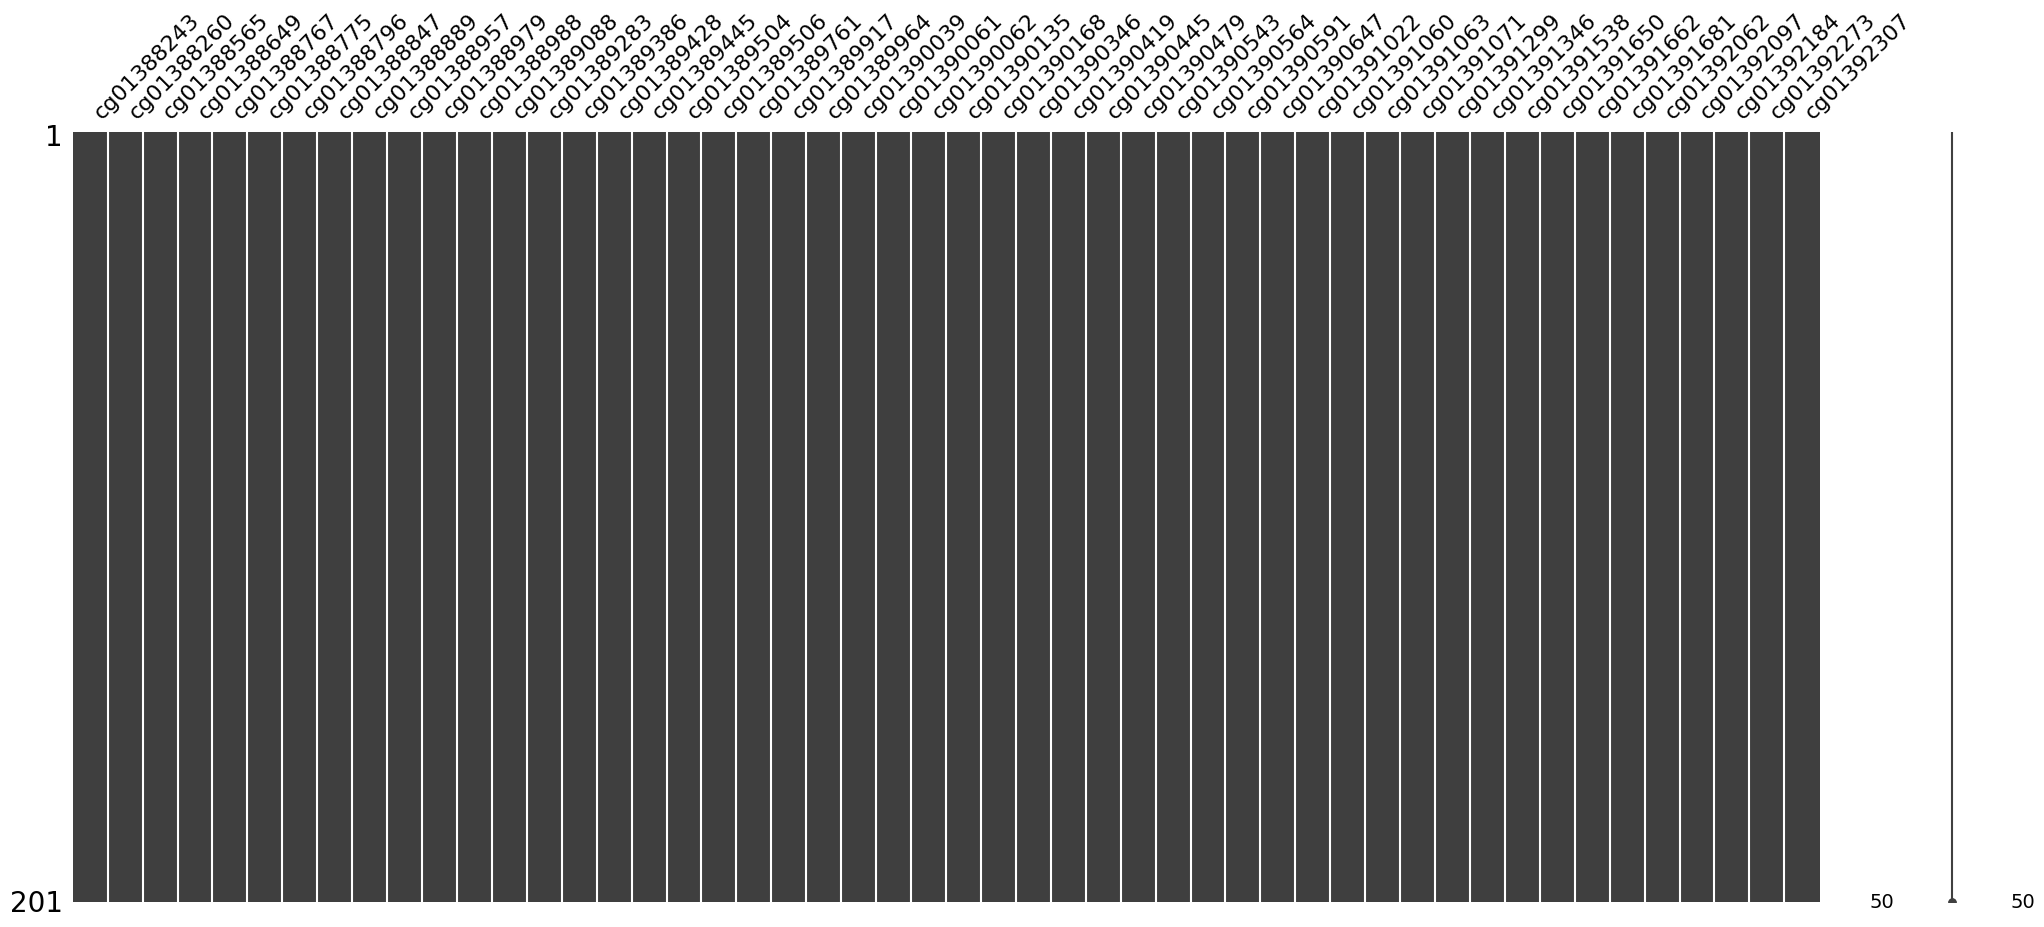

In [10]:
from utils.impute import load_model_and_impute

df = load_model_and_impute(df, model_path='../models/imputer_model.joblib')

# Plot the missing values for a subset
msno.matrix(df.iloc[20000:20050,:].T.reset_index(drop=True))

## Step 8. Remove outliers by PCA

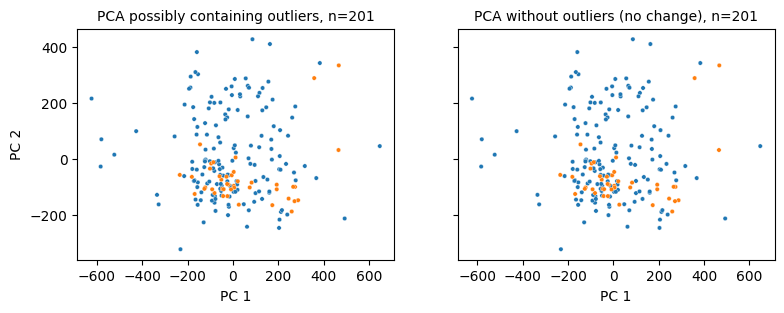

Removed 0 outliers. 201 samples remaining.


[]

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define functions

def standardize_data(df):
    '''Standardizes the data.'''
    return StandardScaler().fit_transform(df.T)

def perform_pca(std_data):
    '''Performs PCA on standardized data.'''
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(std_data)

def create_principal_df(pca_data, df):
    '''Creates a DataFrame with the PCA data.'''
    principal_df = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2'], index=df.columns)
    principal_df['hue'] = df_labels['Clinical Trial']
    return principal_df

def filter_df(df, principal_df, threshold):
    '''Filters the DataFrame by removing outliers.'''
    outliers = principal_df[principal_df['PC1'] >= threshold].index
    return df.drop(outliers, axis=1)

# Execute functions

threshold = 1000
X_std = standardize_data(df)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df)
non_outliers = principal_df[principal_df['PC1'] < threshold]
df = filter_df(df, principal_df, threshold)

# Plot the PCA data

def plot_data(principal_df, non_outliers, threshold):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 3), sharex=True, sharey=True)
    
    for df, ax, title in [(principal_df, ax1,
                                     'PCA possibly containing outliers, n=' + str(principal_df.shape[0])),
                                    (non_outliers, ax2,
                                     'PCA without outliers (no change), n=' + str(non_outliers.shape[0]))]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=False)
        ax.set_title(title, fontsize=10)
        # ax.axvline(x=threshold, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
    plt.show()

plot_data(principal_df, non_outliers, threshold)
print(f'Removed {principal_df.shape[0]-df.shape[1]} outliers. {df.shape[1]} samples remaining.')

# List outliers

outliers = principal_df[principal_df['PC1'] >= threshold].index.to_list()
outliers

## Step 9. Perform batch correction

### Beta-values

In [12]:
from combat.pycombat import pycombat

# Correct batch effects in the training dataset
df_b_values = pycombat(data = df, batch = df_labels.loc[df_labels.index.isin(df.columns)].sort_index()['Clinical Trial']).round(3)

print('Succesfully corrected batch effects in the training dataset.')


Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data
Succesfully corrected batch effects in the training dataset.


### Evaluate batch effects

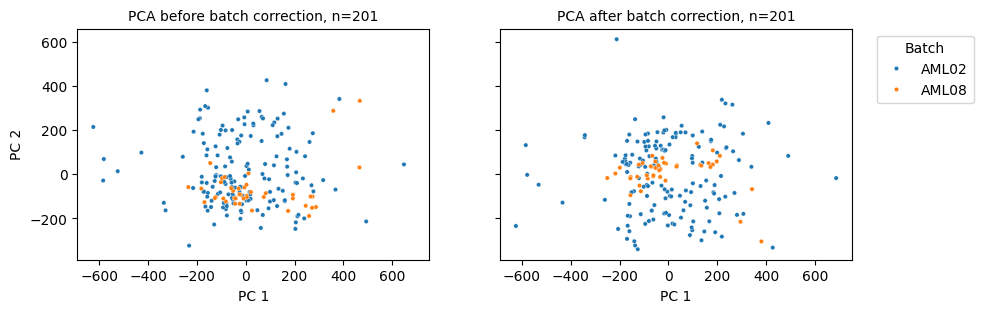

In [13]:
X_std = standardize_data(df_b_values)
principal_components = perform_pca(X_std)
principal_df = create_principal_df(principal_components, df_b_values)

def plot_data(principal_df, non_outliers):
    '''Plots PCA data.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharex=True, sharey=True)
    
    for df, ax, title, legend in [(principal_df, ax2,
                                   'PCA after batch correction, n=' + str(principal_df.shape[0]), 'full'),
                                  (non_outliers, ax1,
                                   'PCA before batch correction, n=' + str(non_outliers.shape[0]), False)]:
        sns.scatterplot(data=df, x='PC1', y='PC2', hue='hue', s=10, alpha=1, ax=ax, legend=legend)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Batch')
    plt.show()

plot_data(principal_df, non_outliers)


## Save batch-corrected beta-values dataset

In [14]:
df_b_values2 = df_b_values.T

dataset_title = f'{df_b_values2.shape[0]}samples_{df_b_values2.shape[1]}cpgs_withbatchcorrection_bvalues.pkl'

df_b_values2.to_pickle(output_path + dataset_title)

print(f'Successfuly saved at: {output_path + dataset_title}')

Successfuly saved at: /mnt/e/ALMA/Intermediate_Files/201samples_331556cpgs_withbatchcorrection_bvalues.pkl


## Save dataset without batch correction

In [15]:
df2 = df.T

dataset_title = f'{df2.shape[0]}samples_{df2.shape[1]}cpgs_nobatchcorrection_bvalues.pkl'

df2.to_pickle(output_path + dataset_title)

print(f'Successfuly saved at: {output_path + dataset_title}')

Successfuly saved at: /mnt/e/ALMA/Intermediate_Files/201samples_331556cpgs_nobatchcorrection_bvalues.pkl


### Evaluate final sample size by batch

In [16]:
# Remove samples that are not in the methyl dataset
df_labels = labels_combined.loc[labels_combined.index.isin(df_b_values2.index)].sort_index()

# # Save the clinical data labels
# df_labels.to_csv(output_path + 'validation_clinical_data.csv')

df_labels['Clinical Trial'].value_counts(dropna=False)

Clinical Trial
AML02    159
AML08     42
Name: count, dtype: int64

## Watermark

In [17]:
%load_ext watermark

In [18]:
%watermark -v -p methylcheck,pandas -a Francisco_Marchi@Lamba_Lab_UF -d -m -r -u

Author: Francisco_Marchi@Lamba_Lab_UF

Last updated: 2024-09-14

Python implementation: CPython
Python version       : 3.8.18
IPython version      : 8.12.3

methylcheck: 0.8.5
pandas     : 2.0.3

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 5.15.133.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Git repo: git@github.com:f-marchi/ALMA.git

